## Food Image Classification with LIME Explanations

Train CNN(s) to classify food images and use LIME to explain predictions.

## 1. Setup and Imports


In [2]:
import os
import random
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import Food101

from lime_cnn_utils import (
    get_data_transforms,
    create_cnn_model,
    train_model,
    evaluate_model,
    explain_prediction,
    visualize_explanation,
    visualize_explanation_detailed,
    compare_architectures,
    plot_images_per_class,
    save_model,
    load_model
)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.9.0
CUDA available: False


## 2. Configuration


In [3]:
# Paths
DATA_ROOT = Path("data").resolve()
MODEL_DIR = Path("models").resolve()
OUTPUT_DIR = Path("output").resolve()
TENSORBOARD_LOG_DIR = Path("runs").resolve()

# Create directories
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
TENSORBOARD_LOG_DIR.mkdir(exist_ok=True)

# Training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 101  # Food-101 has 101 classes

# For faster experimentation, use subset of images

# Class selection configuration
# Option 1: Select specific classes by name (list of class names)
# SELECTED_CLASSES = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']
SELECTED_CLASSES = None  # Set to None to use NUM_CLASSES_TO_USE or all classes

# Option 2: Select number of classes (will randomly select N classes)
NUM_CLASSES_TO_USE = 5  # Set to None to use all classes, or specify a number (e.g., 5)

USE_SUBSET = True  # Set to False for full dataset
TRAIN_SUBSET_SIZE = 500
TEST_SUBSET_SIZE = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Using all {NUM_CLASSES} classes")


Using device: cpu
Using all 101 classes


## 3. Data Preparation: Preprocess and Normalize Images; Apply Data Augmentation

### 3.1 Data Transforms

The `get_data_transforms()` function provides:
- **Training transforms**: Comprehensive data augmentation including:
  - Random crop and resize
  - Random horizontal flip
  - Random rotation
  - Color jitter (brightness, contrast, saturation, hue)
  - Random affine transformations
  - Normalization using ImageNet statistics
- **Validation transforms**: Only resize, center crop, and normalization (no augmentation)


In [4]:
# Get data transforms
train_transform, val_transform = get_data_transforms()

print("Training transforms:")
print(train_transform)
print("\nValidation transforms:")
print(val_transform)


Training transforms:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation transforms:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### 3.2 Load Dataset


In [5]:
# Load Food-101 dataset using JSON metadata (fast method)
import json
from pathlib import Path

# Load metadata JSON files
meta_dir = DATA_ROOT / 'food-101' / 'meta'
train_meta_path = meta_dir / 'train.json'
test_meta_path = meta_dir / 'test.json'

print("Loading metadata files...")
with open(train_meta_path, 'r') as f:
    train_metadata = json.load(f)
with open(test_meta_path, 'r') as f:
    test_metadata = json.load(f)

# Get all available class names from metadata (sorted for consistency)
all_class_names = sorted(train_metadata.keys())

# Determine which classes to use
if SELECTED_CLASSES is not None:
    # Use specified classes
    class_names = [c for c in SELECTED_CLASSES if c in train_metadata]
    if len(class_names) == 0:
        raise ValueError(f"None of the selected classes found: {SELECTED_CLASSES}")
    print(f"\nUsing specified classes: {len(class_names)} classes")
    print(f"  {class_names}")
elif NUM_CLASSES_TO_USE is not None and NUM_CLASSES_TO_USE < len(all_class_names):
    # Randomly select N classes
    import random
    random.seed(42)
    class_names = sorted(random.sample(all_class_names, NUM_CLASSES_TO_USE))
    print(f"\nRandomly selected {NUM_CLASSES_TO_USE} classes:")
    print(f"  {class_names}")
else:
    # Use all classes
    class_names = all_class_names
    print(f"\nUsing all {len(class_names)} classes")

NUM_CLASSES = len(class_names)

print(f"\nDataset metadata loaded:")
print(f"  Selected classes: {NUM_CLASSES}")
print(f"  Training images per class: ~{len(train_metadata[class_names[0]])}")
print(f"  Test images per class: ~{len(test_metadata[class_names[0]])}")
print(f"  Total training images (selected classes): {sum(len(train_metadata[c]) for c in class_names)}")
print(f"  Total test images (selected classes): {sum(len(test_metadata[c]) for c in class_names)}")

# Create balanced subsets using JSON metadata directly
if USE_SUBSET:
    from lime_cnn_utils import create_balanced_subset_from_metadata
    
    print(f"\nCreating balanced subsets from metadata...")
    print(f"  Target training samples: {TRAIN_SUBSET_SIZE}")
    print(f"  Target test samples: {TEST_SUBSET_SIZE}")
    
    train_dataset = create_balanced_subset_from_metadata(
        metadata_path=str(train_meta_path),
        data_root=DATA_ROOT / 'food-101',
        all_class_names=all_class_names,
        total_samples=TRAIN_SUBSET_SIZE,
        transform=train_transform,
        selected_classes=SELECTED_CLASSES,
        num_classes_to_use=NUM_CLASSES_TO_USE,
        random_seed=42
    )
    
    test_dataset = create_balanced_subset_from_metadata(
        metadata_path=str(test_meta_path),
        data_root=DATA_ROOT / 'food-101',
        all_class_names=all_class_names,
        total_samples=TEST_SUBSET_SIZE,
        transform=val_transform,
        selected_classes=SELECTED_CLASSES,
        num_classes_to_use=NUM_CLASSES_TO_USE,
        random_seed=42
    )
    
    print(f"\nBalanced subsets created:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Classes in dataset: {len(train_dataset.classes)}")
else:
    # Load full datasets
    print("\nLoading full datasets (this may take a moment)...")
    # Filter Food101 to only selected classes if specified
    if (
        SELECTED_CLASSES is not None or (NUM_CLASSES_TO_USE is not None and NUM_CLASSES_TO_USE < len(all_class_names))
    ):
        # Get total available samples for selected classes
        total_train = sum(len(train_metadata[c]) for c in class_names)
        total_test = sum(len(test_metadata[c]) for c in class_names)
        
        train_dataset = create_balanced_subset_from_metadata(
            metadata_path=str(train_meta_path),
            data_root=DATA_ROOT / 'food-101',
            all_class_names=all_class_names,
            total_samples=total_train,
            transform=train_transform,
            selected_classes=SELECTED_CLASSES,
            num_classes_to_use=NUM_CLASSES_TO_USE,
            random_seed=42
        )
        
        test_dataset = create_balanced_subset_from_metadata(
            metadata_path=str(test_meta_path),
            data_root=DATA_ROOT / 'food-101',
            all_class_names=all_class_names,
            total_samples=total_test,
            transform=val_transform,
            selected_classes=SELECTED_CLASSES,
            num_classes_to_use=NUM_CLASSES_TO_USE,
            random_seed=42
        )
        
        print(f"  Training samples: {len(train_dataset)}")
        print(f"  Test samples: {len(test_dataset)}")
    else:
        # Load all classes using Food101
        train_dataset_full = Food101(
            root=DATA_ROOT,
            split='train',
            transform=train_transform,
            download=False
        )
        
        test_dataset_full = Food101(
            root=DATA_ROOT,
            split='test',
            transform=val_transform,
            download=False
        )
        
        train_dataset = train_dataset_full
        test_dataset = test_dataset_full
        print(f"  Training samples: {len(train_dataset)}")
        print(f"  Test samples: {len(test_dataset)}")


Loading metadata files...

Randomly selected 5 classes:
  ['beef_carpaccio', 'carrot_cake', 'escargots', 'ramen', 'strawberry_shortcake']

Dataset metadata loaded:
  Selected classes: 5
  Training images per class: ~750
  Test images per class: ~250
  Total training images (selected classes): 3750
  Total test images (selected classes): 1250

Creating balanced subsets from metadata...
  Target training samples: 500
  Target test samples: 100

Balanced subsets created:
  Training samples: 500
  Test samples: 100
  Classes in dataset: 5


### 3.3 Dataset Statistics: Images per Class

Visualize the distribution of images across classes in the training and test datasets.

Plot saved to /Users/damith/lime/output/images_per_class_distribution.png


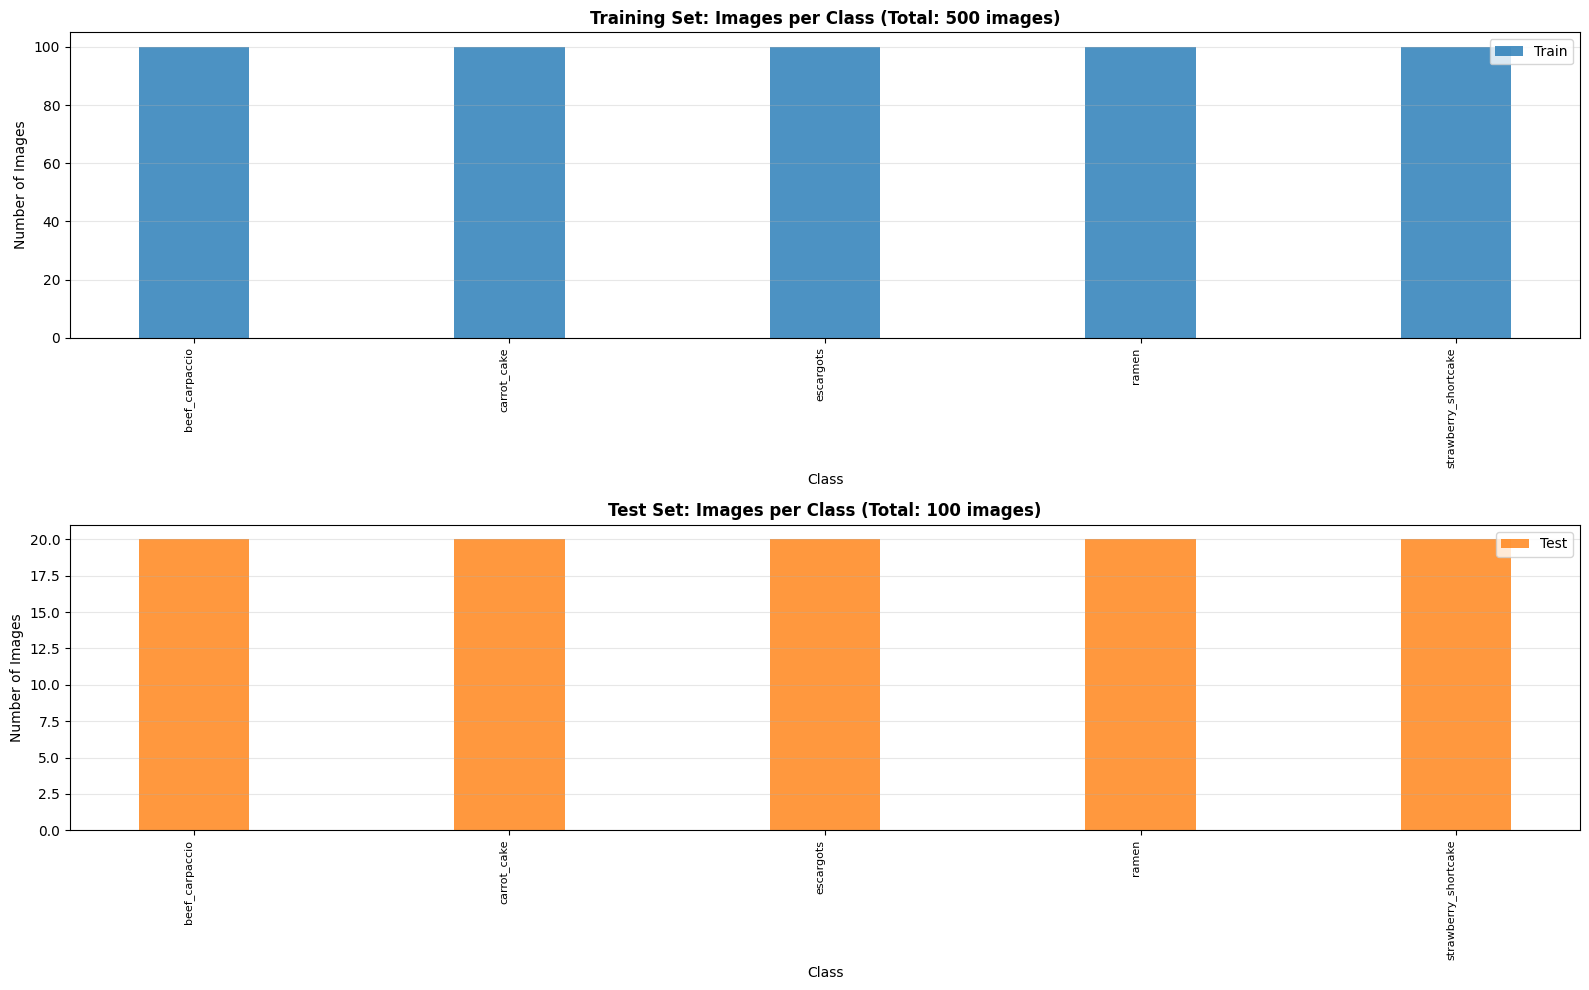

In [6]:
# Plot images per class distribution
plot_images_per_class(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    class_names=class_names,
    save_path=str(OUTPUT_DIR / 'images_per_class_distribution.png')
)

### 3.4 Visualize Data Augmentation

Let's visualize how data augmentation transforms the images:


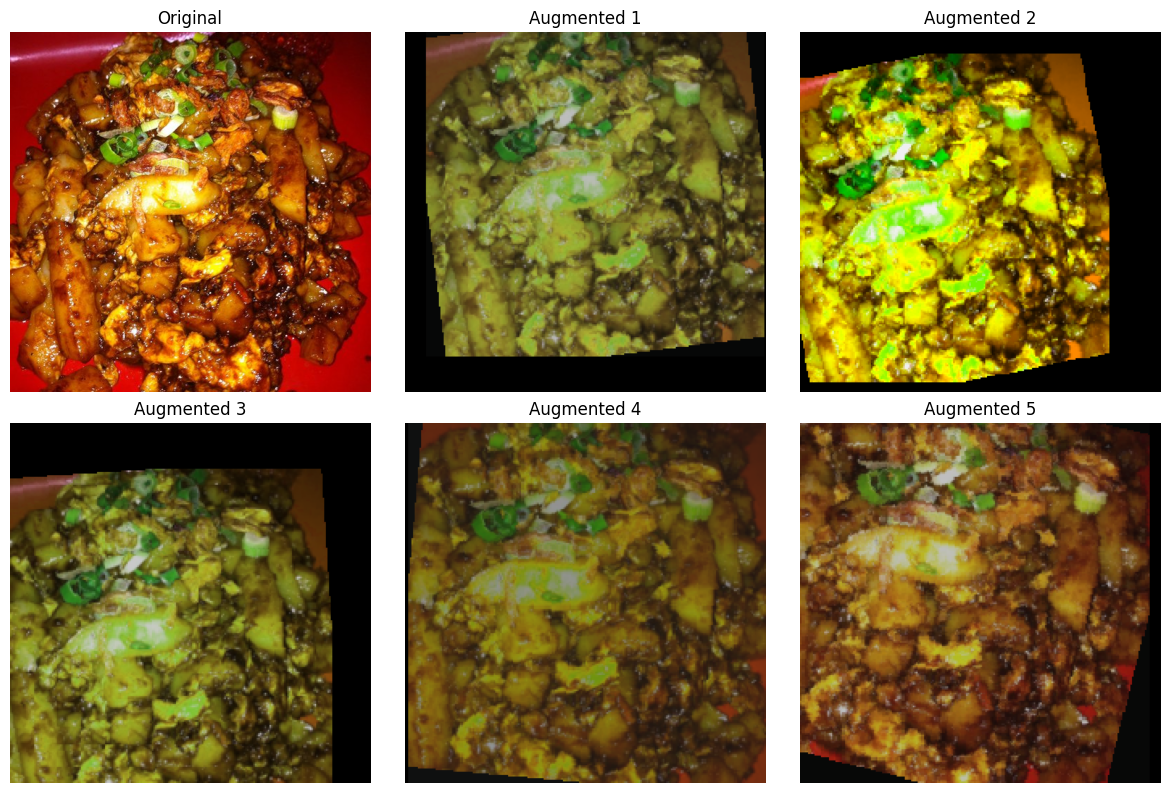

In [7]:
# Get a sample image from the training dataset
sample_idx = 0
sample_image, sample_label = train_dataset[sample_idx]

# Apply training transform multiple times to see augmentation
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Load original image
original_path = train_dataset._image_files[sample_idx]
original_img = Image.open(original_path).convert('RGB')

axes[0, 0].imshow(original_img)
axes[0, 0].set_title(f"Original")
axes[0, 0].axis('off')

# Show 5 augmented versions
for i in range(5):
    aug_image, _ = train_dataset[sample_idx]
    # Convert tensor back to image for visualization
    aug_image_np = aug_image.permute(1, 2, 0).numpy()
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    aug_image_np = aug_image_np * std + mean
    aug_image_np = np.clip(aug_image_np, 0, 1)
    
    row = (i + 1) // 3
    col = (i + 1) % 3
    if row < 2 and col < 3:
        axes[row, col].imshow(aug_image_np)
        axes[row, col].set_title(f"Augmented {i+1}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'data_augmentation_examples.png', dpi=150)
plt.show()

### 3.5 Create Data Loaders


In [8]:
# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Data loaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Data loaders created:
  Training batches: 7
  Validation batches: 2
  Test batches: 2


## 4. Model Construction: Train a Convolutional Neural Network using PyTorch

### 4.1 Train Models


In [ ]:
# Create and train all models for comparison
architectures_to_train = ['resnet18', 'resnet50', 'efficientnet_b0']

models = [
    create_cnn_model(num_classes=NUM_CLASSES, architecture=architecture, pretrained=True) 
    for architecture in architectures_to_train
]

trained_models = {}
training_histories = {}

for arch in architectures_to_train:
    print(f"\nTraining {arch.upper()}")
    
    # Create model
    model = create_cnn_model(
        num_classes=NUM_CLASSES,
        architecture=arch,
        pretrained=True
    )
    
    print(f"Model: {arch}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    model = model.to(device)
    
    # Train model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        device=device,
        learning_rate=LEARNING_RATE,
        log_dir=str(TENSORBOARD_LOG_DIR)
    )
    
    # Save model
    model_path = MODEL_DIR / f"food_classifier_{arch}.pth"
    # Get class_to_idx from dataset
    if hasattr(train_dataset, 'class_to_idx'):
        class_to_idx_to_save = train_dataset.class_to_idx
    else:
        class_to_idx_to_save = {name: idx for idx, name in enumerate(class_names)}
    
    save_model(model, str(model_path), class_to_idx_to_save)
    
    trained_models[arch] = model
    training_histories[arch] = history

## 5. Evaluation: Assess Accuracy and Interpretability

### 5.1 Evaluate Model Accuracy


In [10]:
models = {
    architecture: create_cnn_model(num_classes=NUM_CLASSES, architecture=architecture, pretrained=True) 
    for architecture in architectures_to_train
}

In [11]:
# Load models

model_resnet18 = load_model(MODEL_DIR / 'food_classifier_resnet18.pth', model=models['resnet18'], device=device)['model']
model_resnet50 = load_model(MODEL_DIR / 'food_classifier_resnet50.pth', model=models['resnet50'], device=device)['model']
model_efficientnet_b0 = load_model(MODEL_DIR / 'food_classifier_efficientnet_b0.pth', model=models['efficientnet_b0'], device=device)['model']

In [11]:
# Evaluate on test set
print("Evaluating ResNet-18 on test set...")
results_resnet18 = evaluate_model(model_resnet18, test_loader, device=device)

print(f"\nResNet-18:")
print(f"Accuracy: {results_resnet18['accuracy']:.2f}%")
print(f"Correct: {results_resnet18['correct']}/{results_resnet18['total']}")
print(f"Total: {results_resnet18['total']}")

print("\nEvaluating ResNet-50 on test set...")
results_resnet50 = evaluate_model(model_resnet50, test_loader, device=device)

print(f"\nResNet-50:")
print(f"Accuracy: {results_resnet50['accuracy']:.2f}%")
print(f"Correct: {results_resnet50['correct']}/{results_resnet50['total']}")
print(f"Total: {results_resnet50['total']}")

print("\nEvaluating EfficientNet-B0 on test set...")
results_efficientnet_b0 = evaluate_model(model_efficientnet_b0, test_loader, device=device)

print(f"\nEfficientNet-B0:")
print(f"Accuracy: {results_efficientnet_b0['accuracy']:.2f}%")
print(f"Correct: {results_efficientnet_b0['correct']}/{results_efficientnet_b0['total']}")
print(f"Total: {results_efficientnet_b0['total']}\n")


Evaluating ResNet-18 on test set...


Evaluating: 100%|█████████████████████████| 2/2 [00:13<00:00,  6.62s/it, acc=89.00%, correct=89/100]



ResNet-18:
Accuracy: 89.00%
Correct: 89/100
Total: 100

Evaluating ResNet-50 on test set...


Evaluating: 100%|█████████████████████████| 2/2 [00:17<00:00,  8.66s/it, acc=89.00%, correct=89/100]



ResNet-50:
Accuracy: 89.00%
Correct: 89/100
Total: 100

Evaluating EfficientNet-B0 on test set...


Evaluating: 100%|█████████████████████████| 2/2 [00:15<00:00,  7.99s/it, acc=86.00%, correct=86/100]


EfficientNet-B0:
Accuracy: 86.00%
Correct: 86/100
Total: 100



## 6. LIME Integration: Apply LIME to Generate Explanations with Highlighted Regions

### 6.1 Select Test Image


Selected test image: /Users/damith/lime/data/food-101/images/carrot_cake/3341984.jpg
True label: carrot_cake


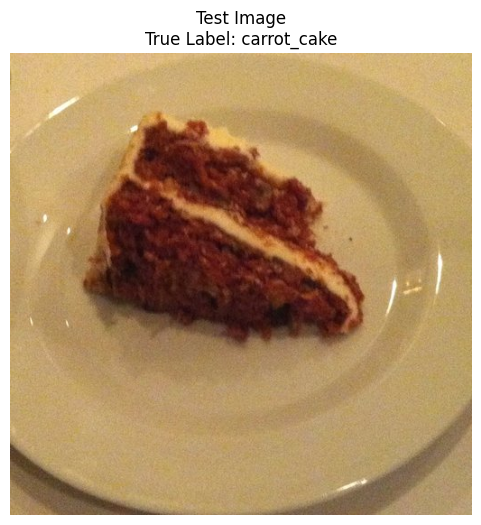

In [29]:
# Select a random test image
test_image_idx = random.randint(0, len(test_dataset) - 1)

# Get image, label, and path
image, test_image_label = test_dataset[test_image_idx]
test_image_path = test_dataset._image_files[test_image_idx]

print(f"Selected test image: {test_image_path}")
print(f"True label: {class_names[test_image_label]}")

# Display image
img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Test Image\nTrue Label: {class_names[test_image_label]}")
plt.axis('off')
plt.show()

### 6.2 Generate LIME Explanation

LIME uses superpixels to segment the image and identify which regions contribute to the prediction.

Lime will:

1. Segment the image into superpixels
2. Create variations by turning superpixels on and off
3. Get predictions for each variation
4. Identify which superpixels contribute the most to the prediction

In [30]:
# Generate LIME explanation
print("Generating LIME explanation (this may take a few minutes)...")
print("LIME will:")
print("  1. Segment the image into superpixels")
print("  2. Create variations by turning superpixels on/off")
print("  3. Get predictions for each variation")
print("  4. Identify which superpixels contribute most to the prediction")

lime_explanation = explain_prediction(
    image_path=test_image_path,
    model=model_resnet18,
    class_names=class_names,
    device=device,
    num_features=50,  # Number of superpixels to highlight
    num_samples=500,  # Number of variations to test
    top_labels=5  # Number of top predictions to explain
)

print(f"\nPredicted class: {lime_explanation['top_label_name']}")
print(f"\nTop 5 predictions:")
for class_name, prob in lime_explanation['top_probabilities']:
    print(f"  {class_name}: {prob:.4f}")


Generating LIME explanation (this may take a few minutes)...
LIME will:
  1. Segment the image into superpixels
  2. Create variations by turning superpixels on/off
  3. Get predictions for each variation
  4. Identify which superpixels contribute most to the prediction


  0%|          | 0/500 [00:00<?, ?it/s]


Predicted class: carrot_cake

Top 5 predictions:
  carrot_cake: 1.0000
  ramen: 0.0000
  beef_carpaccio: 0.0000
  escargots: 0.0000
  strawberry_shortcake: 0.0000


### 6.3 Visualize LIME Explanation with Highlighted Regions


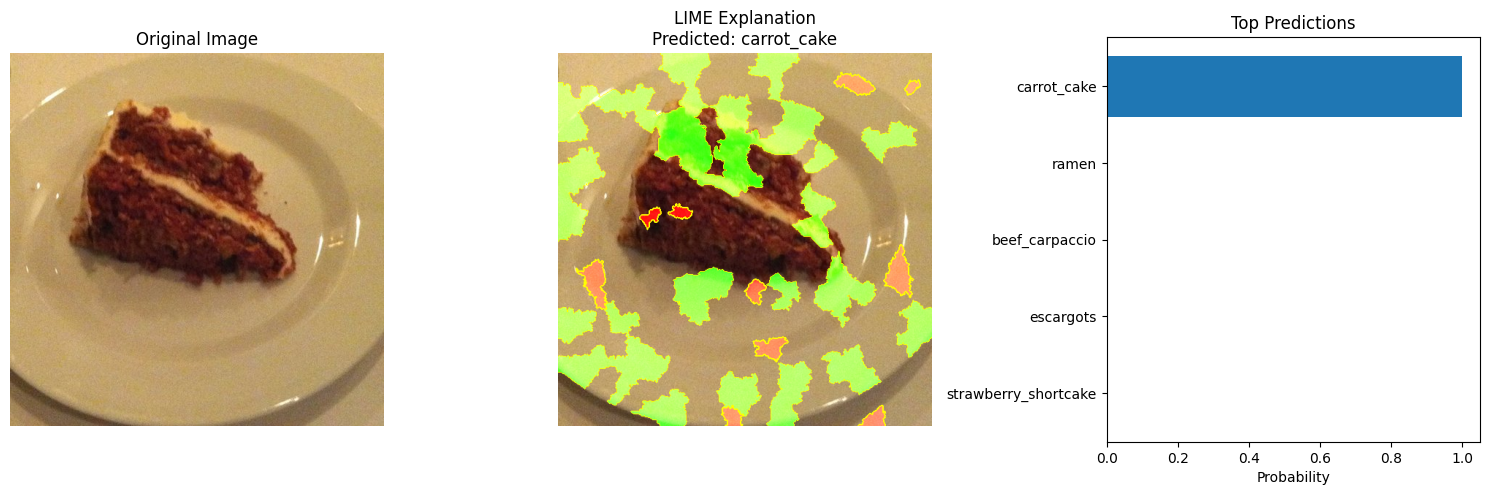

In [31]:
# Visualize explanation
visualize_explanation(
    lime_explanation,
    save_path=str(OUTPUT_DIR / 'lime_explanation_resnet50.png')
)

### 6.4 Detailed Visualization: Positive and Negative Contributions


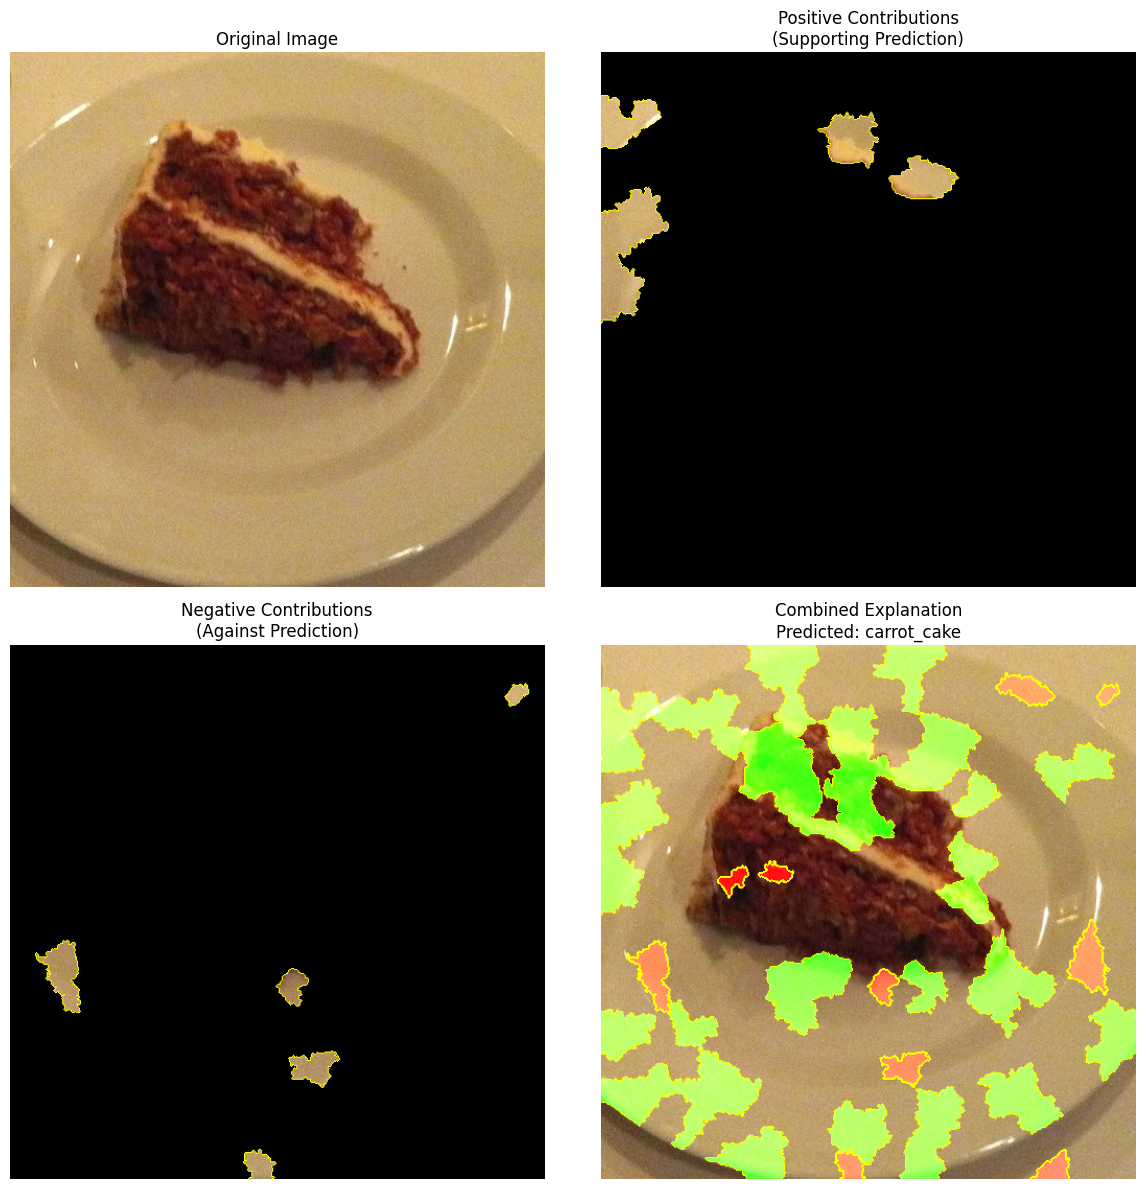

In [32]:
# Detailed visualization showing positive and negative contributions
visualize_explanation_detailed(
    lime_explanation,
    save_path=str(OUTPUT_DIR / 'lime_explanation_detailed_resnet50.png')
)

## 7. Compare Deeper Architectures (ResNet, EfficientNet)

Let's compare ResNet-18, ResNet-50, and EfficientNet-B0 to see how architecture depth affects both accuracy and interpretability.


In [33]:
# Compare architectures by loading pretrained models
architectures_to_compare = ['resnet18', 'resnet50', 'efficientnet_b0']

print("Comparing architectures:")
print(f"  {architectures_to_compare}")
print(f"\nLoading pretrained models from {MODEL_DIR}...")

comparison_results = compare_architectures(
    architectures=architectures_to_compare,
    test_loader=test_loader,
    num_classes=NUM_CLASSES,
    model_dir=str(MODEL_DIR),
    device=device
)


Comparing architectures:
  ['resnet18', 'resnet50', 'efficientnet_b0']

Loading pretrained models from /Users/damith/lime/models...

Loading resnet18
Model loaded from /Users/damith/lime/models/food_classifier_resnet18.pth
Model parameters: 11,179,077


Evaluating: 100%|█████████████████████████| 2/2 [00:14<00:00,  7.01s/it, acc=89.00%, correct=89/100]


resnet18 Test Accuracy: 89.00%

Loading resnet50
Model loaded from /Users/damith/lime/models/food_classifier_resnet50.pth
Model parameters: 23,518,277


Evaluating: 100%|█████████████████████████| 2/2 [00:17<00:00,  8.92s/it, acc=89.00%, correct=89/100]


resnet50 Test Accuracy: 89.00%

Loading efficientnet_b0
Model loaded from /Users/damith/lime/models/food_classifier_efficientnet_b0.pth
Model parameters: 4,013,953


Evaluating: 100%|█████████████████████████| 2/2 [00:16<00:00,  8.05s/it, acc=86.00%, correct=86/100]

efficientnet_b0 Test Accuracy: 86.00%


### 7.2 Compare Architecture Performance


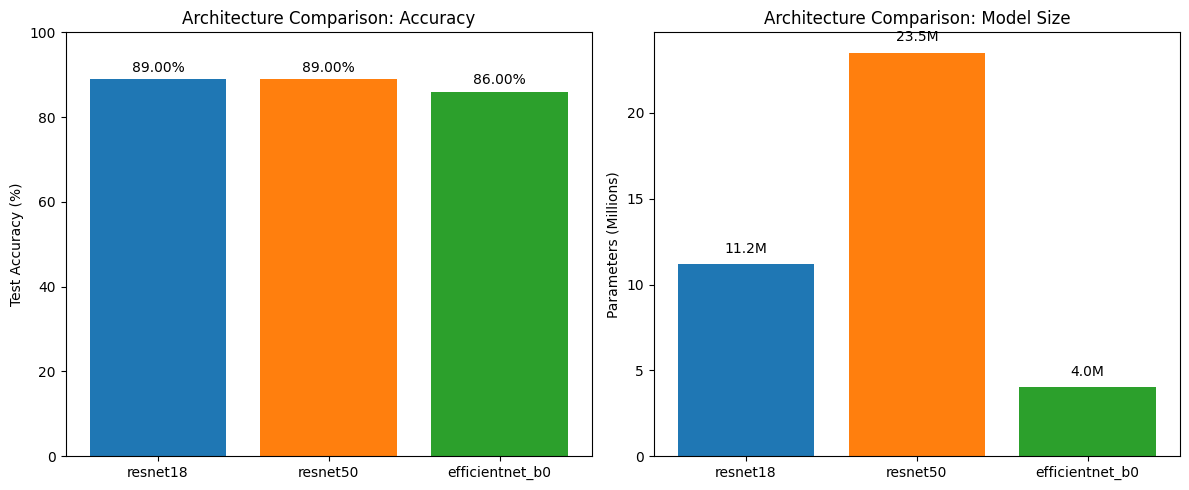


Architecture Comparison Summary:

RESNET18:
  Test Accuracy: 89.00%
  Parameters: 11,179,077

RESNET50:
  Test Accuracy: 89.00%
  Parameters: 23,518,277

EFFICIENTNET_B0:
  Test Accuracy: 86.00%
  Parameters: 4,013,953


In [34]:
# Visualize comparison results
arch_names = list(comparison_results.keys())
accuracies = [comparison_results[arch]['test_accuracy'] for arch in arch_names]
num_params = [comparison_results[arch]['num_parameters'] for arch in arch_names]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].bar(arch_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Architecture Comparison: Accuracy')
axes[0].set_ylim([0, 100])
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 1, f'{acc:.2f}%', ha='center', va='bottom')

# Parameter count comparison
axes[1].bar(arch_names, [p/1e6 for p in num_params], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('Parameters (Millions)')
axes[1].set_title('Architecture Comparison: Model Size')
for i, params in enumerate(num_params):
    axes[1].text(i, params/1e6 + 0.5, f'{params/1e6:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'architecture_comparison.png', dpi=150)
plt.show()

print("\nArchitecture Comparison Summary:")
for arch in arch_names:
    print(f"\n{arch.upper()}:")
    print(f"  Test Accuracy: {comparison_results[arch]['test_accuracy']:.2f}%")
    print(f"  Parameters: {comparison_results[arch]['num_parameters']:,}")


### 7.3 Compare Interpretability Across Architectures

Now let's generate LIME explanations for the same image using different architectures to compare interpretability.


In [37]:
# Generate explanations for the same image using different architectures
print(f"Generating LIME explanations for the same image using different architectures...")
print(f"Image: {test_image_path}")
print(f"True label: {class_names[test_image_label]}")

explanations = {}
for arch in architectures_to_compare:
    print(f"\nGenerating explanation for {arch}...")
    model = comparison_results[arch]['model']
    explanations[arch] = explain_prediction(
        image_path=test_image_path,
        model=model,
        class_names=class_names,
        device=device,
        num_features=50,
        num_samples=100,
        top_labels=5
    )
    print(f"  Predicted: {explanations[arch]['top_label_name']}")
    print(f"  Confidence: {explanations[arch]['top_probabilities'][0][1]:.4f}")


Generating LIME explanations for the same image using different architectures...
Image: /Users/damith/lime/data/food-101/images/carrot_cake/3341984.jpg
True label: carrot_cake

Generating explanation for resnet18...


  0%|          | 0/100 [00:00<?, ?it/s]

  Predicted: carrot_cake
  Confidence: 1.0000

Generating explanation for resnet50...


  0%|          | 0/100 [00:00<?, ?it/s]

  Predicted: carrot_cake
  Confidence: 1.0000

Generating explanation for efficientnet_b0...


  0%|          | 0/100 [00:00<?, ?it/s]

  Predicted: escargots
  Confidence: 1.0000


### 7.4 Visualize Interpretability Comparison


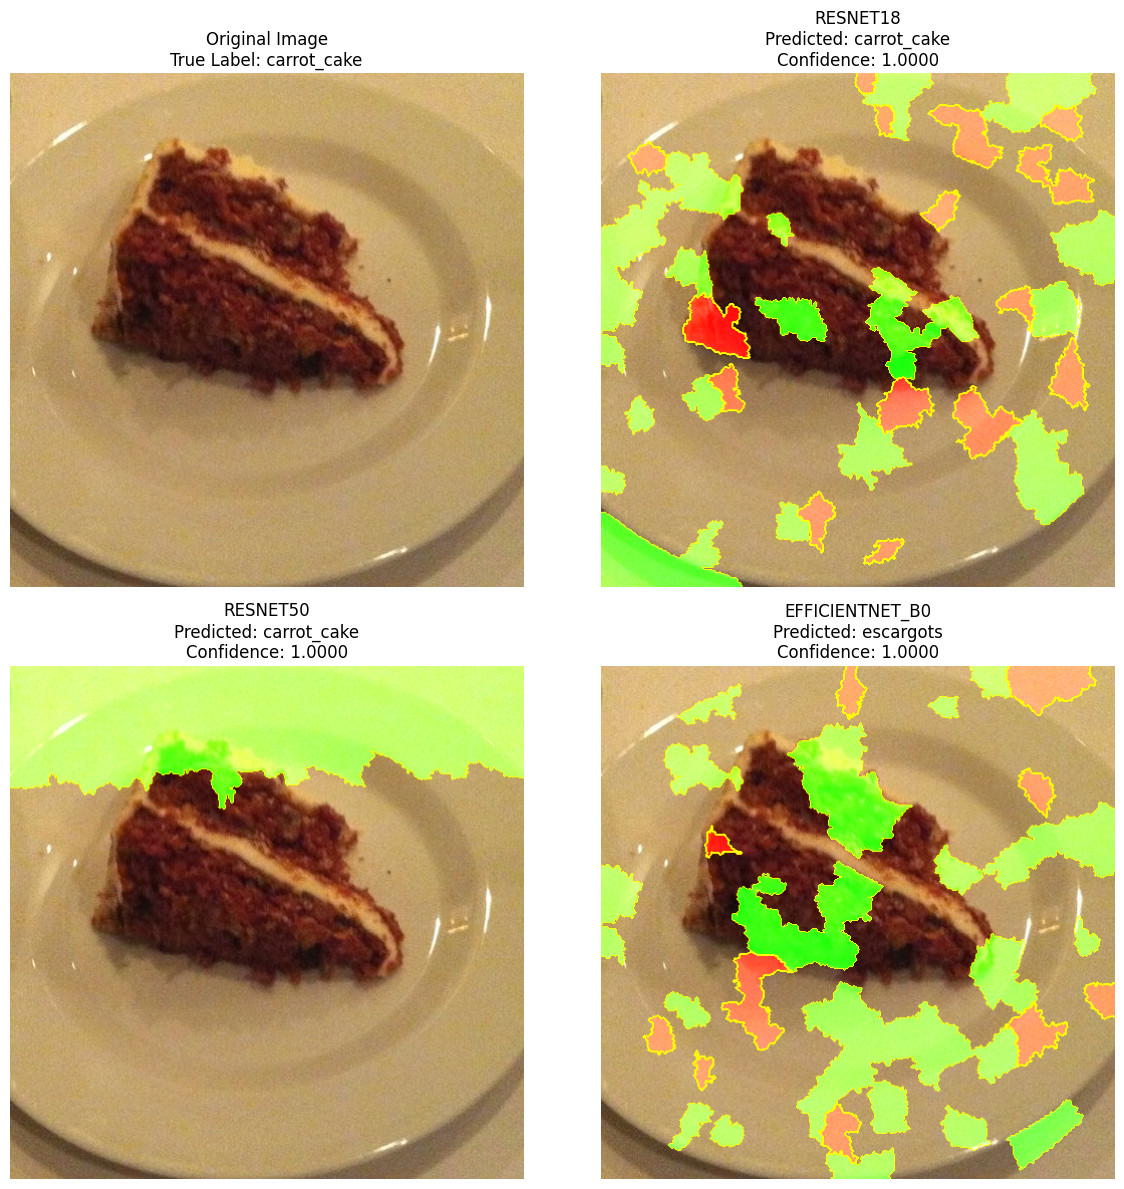

In [38]:
# Visualize explanations in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Show original image in top left
if len(explanations) > 0:
    first_exp = explanations[list(explanations.keys())[0]]
    axes[0, 0].imshow(first_exp['image'])
    axes[0, 0].set_title(f"Original Image\nTrue Label: {class_names[test_image_label]}")
    axes[0, 0].axis('off')

# Show LIME explanations for each architecture
arch_list = list(explanations.keys())
positions = [(0, 1), (1, 0), (1, 1)]  # Remaining 3 positions in 2x2 grid

for idx, arch in enumerate(arch_list[:3]):  # Show up to 3 architectures
    if idx >= len(positions):
        break
    
    exp = explanations[arch]
    row, col = positions[idx]
    
    axes[row, col].imshow(exp['visualization'])
    axes[row, col].set_title(
        f"{arch.upper()}\n"
        f"Predicted: {exp['top_label_name']}\n"
        f"Confidence: {exp['top_probabilities'][0][1]:.4f}"
    )
    axes[row, col].axis('off')

# Hide unused subplots if we have fewer than 3 architectures
if len(arch_list) < 3:
    for idx in range(len(arch_list), 3):
        row, col = positions[idx]
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'interpretability_comparison.png', dpi=150)
plt.show()